In [4]:
# https://blog.floydhub.com/spinning-up-with-deep-reinforcement-learning/
import gym
import random
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display
from keras.layers import Dense
from keras.models import Sequential

Using TensorFlow backend.


In [14]:
# Collect a game of Pong with random input.
frames = []
frames_ram = []
STEPS = 300

UP_ACTION = 2
DOWN_ACTION = 3

env = gym.make("Pong-ram-v0")

observation = env.reset()

for i in range(STEPS):
    gym.envs.registry
    action = random.randint(UP_ACTION, DOWN_ACTION)

    observation, reward, done, info = env.step(action)
    frames.append(env.unwrapped._get_image())
    frames_ram.append(env.unwrapped._get_ram())
    
    if done:
        observation = env.reset()
        frames.append(observation)

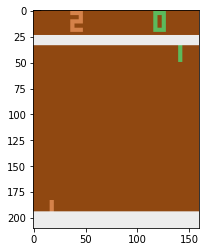

KeyboardInterrupt: 

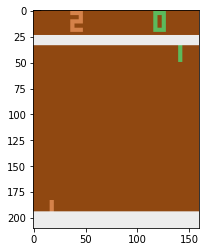

In [20]:
# Draw our frames to see what happened.
for i in range(len(frames)):
    plt.imshow(frames[i])
    print(frames_ram[i])
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.5)


In [6]:
# Create the neural network.
# TODO: extract from the ram the ball position, ball direction, ball speed, panel position
# TODO: What is a adam optimizer?
model = Sequential()
model.add(Dense(units=200,input_dim=80*80, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dense(units=1, activation='sigmoid', kernel_initializer='RandomNormal'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])